In [90]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from matplotlib import dates
import plotly.graph_objs as go
import plotly.offline as pyoff

In [111]:
df = pd.read_excel('itService.xlsx')

df = df.drop(['YY', 'MM'], axis=1)
df['YYMM'] = df['YYMM'].astype(str)

df['YYMM'] = df['YYMM'] + "01"
df['YYMM'] = pd.to_datetime(df['YYMM'])
df
#df['YYMM'] = pd.to_datetime(df['YYMM'], infer_datetime_format=True)

#df['YYMM'] = df['YYMM'].dt.strftime('%Y%M')#
#df.info()

#df['YY'] = pd.to_string(columns = ['YY'])
#df['YY'] = df['YY'].astype(str)

#df['MM'] = df['MM'].astype(str).zfill(2)
#df['Full Name'] = df[['YY', 'MM']].agg(''.join, axis=1)

#df.info()
#df.head()
#df = df.loc[:,'MM':'CNT']
#df['Full Name'] = df[['YY', 'MM']].agg(' '.join, axis=1)

#cols = ['YY', 'MM']
#df['combined'] =df[cols].apply(lambda row: '-'.join(row.values.astype(str)), axis=1)
#df

,YYMM,CNT
0,2013-05-01,14
1,2013-06-01,70
2,2013-07-01,25
3,2013-08-01,15
4,2013-09-01,13
...,...,...
99,2021-08-01,127
100,2021-09-01,107
101,2021-10-01,137
102,2021-11-01,143


In [112]:
#plot 
plot_data = [
    go.Scatter(
        x=df['YYMM'],
        y=df['CNT'],
    )
]
plot_layout = go.Layout(
        title='ITService'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

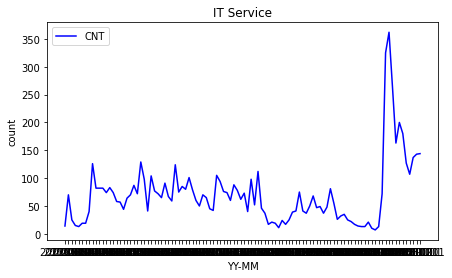

In [104]:
plt.figure(figsize=(7,4))

plt.title('IT Service')
plt.ylabel('count')
plt.xlabel('YY-MM')

plt.plot(df['YYMM'], df['CNT'], label='CNT', color='b')
plt.legend(loc='best')

plt.show()

In [105]:
print(df.describe())
print(df.isnull().sum())

              CNT
count  104.000000
mean    70.365385
std     58.208874
min      7.000000
25%     36.500000
50%     63.000000
75%     82.250000
max    362.000000
YYMM    0
CNT     0
dtype: int64


In [106]:
scale_cols = df.columns.values.tolist()[:]
scale_cols

['YYMM', 'CNT']

In [107]:
# 정규화 날짜를 제외한 나머지 숫자에 대해서 모든컬럼에 0~1값으로 정규화 수행
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# 날짜를 제외한 컬럼 가져오기
#scale_cols = df.columns.values.tolist()[1:]
scale_cols = df.columns.values.tolist()[1:]


# 정규화 수행
scaled_df = scaler.fit_transform(df[scale_cols]) 

# numpy 리턴
print(type(scaled_df))

# 정규화된 데이터 프레임 생성
scaled_df = pd.DataFrame(scaled_df, columns=scale_cols)
print(scaled_df)


<class 'numpy.ndarray'>
          CNT
0    0.019718
1    0.177465
2    0.050704
3    0.022535
4    0.016901
..        ...
99   0.338028
100  0.281690
101  0.366197
102  0.383099
103  0.385915

[104 rows x 1 columns]


In [108]:
# 입력데이터
feature_cols = ['YYMM'] 
## 정답데이터
label_cols = ['CNT']  

feature_df = pd.DataFrame(scaled_df, columns=feature_cols)
label_df = pd.DataFrame(scaled_df, columns=label_cols)

print(feature_df, label_df)

     YYMM
0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
..    ...
99    NaN
100   NaN
101   NaN
102   NaN
103   NaN

[104 rows x 1 columns]           CNT
0    0.019718
1    0.177465
2    0.050704
3    0.022535
4    0.016901
..        ...
99   0.338028
100  0.281690
101  0.366197
102  0.383099
103  0.385915

[104 rows x 1 columns]


In [79]:
# 딥러닝 학습을 위한 넘파이로 변환
feature_np = feature_df.to_numpy()
label_np = label_df.to_numpy()

print(feature_np.shape, label_np.shape)

(104, 1) (104, 1)


In [80]:
def make_sequence_dataset(feature, label, window_size):
    
    feature_list = [] 
    label_list = []
    
    for i in range(len(feature) - window_size):
        
        feature_list.append(feature[i:i+window_size])
        label_list.append(label[i+window_size])
           #3차원 텐서 변환 
    return np.array(feature_list), np.array(label_list)

In [81]:
## 시계열 데이터 생성
window_size = 1

X, Y = make_sequence_dataset(feature_np, label_np, window_size)

print(X.shape, Y.shape)

(103, 1, 1) (103, 1)


In [82]:
## 데이터 나누기 
split = -3

x_train = X[0:split]
y_train = Y[0:split]

x_test = X[split:]
y_test = Y[split:]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(100, 1, 1) (100, 1)
(3, 1, 1) (3, 1)


In [83]:
## LSTM 모델 구축

model = Sequential()

model.add(LSTM(256,
               activation='tanh',
               input_shape=x_train[0].shape))

model.add(Dense(1, activation='linear'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 256)               264192    
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 264,449
Trainable params: 264,449
Non-trainable params: 0
_________________________________________________________________


In [84]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(loss='mse', optimizer='adam', metrics=['mae'])
## 특정값이 올때까지 조기 종료
early_stop = EarlyStopping(monitor='val_loss', patience=5)

hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=16, callbacks=[early_stop])

Epoch 1/100
7/7 [==============================] - 1s 49ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 2/100
7/7 [==============================] - 0s 4ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 3/100
7/7 [==============================] - 0s 4ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 4/100
7/7 [==============================] - 0s 5ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 5/100
7/7 [==============================] - 0s 5ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan


In [85]:
model.evaluate(x_test, y_test)

1/1 [==============================] - 0s 14ms/step - loss: nan - mae: nan


[nan, nan]

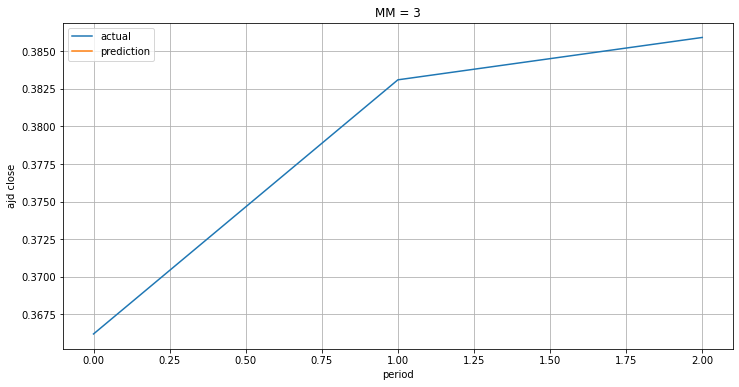

In [86]:
pred = model.predict(x_test)

plt.figure(figsize=(12,6))
plt.title('MM = 3')
plt.ylabel('ajd close')
plt.xlabel('period')
plt.plot(y_test, label='actual')
plt.plot(pred, label='prediction')
plt.grid()
plt.legend(loc='best')

plt.show()